In [17]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *

import numpy as np
import pandas as pd

import pytraj as pt
import mdtraj as md

import pickle
import os
import sys

import random

from glob import glob

import free_energy_clustering as FEC

## References and trajectories

In [2]:
rf0=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot0.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7')

rf1=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot1.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7')

rf2=pt.load('../1-Trajectories/0-Parm_rst//closed6_dry_rot2.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7')

rf3=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot3.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7')

rf4=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot4.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7')

rf5=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot5.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7')

rfopen=pt.load('../1-Trajectories/0-Parm_rst/open10_dry.rst7',
               '../1-Trajectories/0-Parm_rst/open10_dry.parm7')

In [3]:
indir1 = '../1-Trajectories/1-NoEq_without_IPA'
# indir2 = '../1-Trajectories/4-Adaptive_sampling_with_IPA'
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'

traj_list1 = sorted(glob(indir1+'/*.nc'))
# traj_list2 = sorted(glob(indir2+'/*.nc'))

traj_list=traj_list1# +traj_list2
traj_list

['../1-Trajectories/1-NoEq_without_IPA/closed_dry_01.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_02.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_03.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_04.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_05.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_06.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_07.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_08.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_09.nc',
 '../1-Trajectories/1-NoEq_without_IPA/closed_dry_10.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_01.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_02.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_03.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_04.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_05.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_06.nc',
 '../1-Trajectories/1-NoEq_without_IPA/open_dry_07.nc',
 '../1-Trajectories/1-NoEq_w

## GMM construction with limited dataset

First the GMM is built using uncorrelated data. We assume the data to be uncorrelated for a frame every 500 ps (dt=5)

The trajectory is therefore first loaded with a stride of 5

In [4]:
traj = pt.iterload(traj_list, topfile, stride=5)

The RMSD is then calculated. Because of the symmerty and chain IDs, 6 references are used for the closed form (simplky corresponding to a rotation of the chain IDs, and the minimum RMSD is retained

In [6]:
rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")

rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)

rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")

We construct a array Z with the RMSD to the closed form and to the open form for each frame of the reduced trajectory

In [7]:
Z=[]
for i in range(0,len(rmsd_open)):
    a=np.array([rmsd_closed[i],rmsd_open[i]])
    Z.append(a)
Z=np.array(Z)

In [8]:
with open('./pickled/2-Without_IPA/Z_dt5.pickle', 'wb') as outf:
    pickle.dump(Z, outf)
    
# with open('./pickled/2-Without_IPA/Z_dt5.pickle', 'rb') as inf:
#     Z = pickle.load(inf)

We need to find the optimum number of components for constructing the GMM so we screen for a window of 2 to 20 components.

In [10]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=5, max_n_components=25, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=5, n_grids=151, n_splits=1,stack_landscapes=False)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 5
   max_n_components = 25
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 5
# Components = 6
# Components = 7
# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
# Components = 13
# Components = 14
# Components = 15
# Components = 16
# Components = 17
# Components = 18
# Components = 19
# Components = 20
# Components = 21
# Components = 22
# Components = 23
# Components = 24
# Components = 25
Identifying final model with 11 components.
Evaluating density in landscape
Density grid shape: [151, 151]


The optimum number of components is 10, so we build and save a GMM with that many components

In [9]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=10, max_n_components=10, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=5, n_grids=151, n_splits=1,stack_landscapes=False)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 10
   max_n_components = 10
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 10
Identifying final model with 10 components.
Evaluating density in landscape
Density grid shape: [151, 151]


In [11]:
with open('./pickled/2-Without_IPA/coords_dt5.pickle', 'wb') as outf:
    pickle.dump(coords, outf)
with open('./pickled/2-Without_IPA/FE_landscape_dt5.pickle', 'wb') as outf:
    pickle.dump(FE_landscape, outf)
with open('./pickled/2-Without_IPA/FE_points_dt5.pickle', 'wb') as outf:
    pickle.dump(FE_points, outf)
    
# with open('./pickled/2-Without_IPA/coords_dt5.pickle', 'rb') as inf:
#     coords = pickle.load(inf)
# with open('./pickled/2-Without_IPA/FE_landscape_dt5.pickle', 'rb') as inf:
#     FE_landscape = pickle.load(inf)
# with open('./pickled/2-Without_IPA/FE_points_dt5.pickle', 'rb') as inf:
#     FE_points = pickle.load(inf)

# fec.FE_points_ = np.copy(FE_landscape)
# fec.FE_landscape_ = np.copy(FE_landscape)
# fec.coords_ = coords   

We can then plot the FES

/mnt/storage/scratch/el14718/10-ALKEIG/12-Analysis_4/11-InfleCS_clustering_3/free_energy_clustering/GMM_free_energy.py:537: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("nipy_spectral"))
  my_cmap.set_over('white')
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


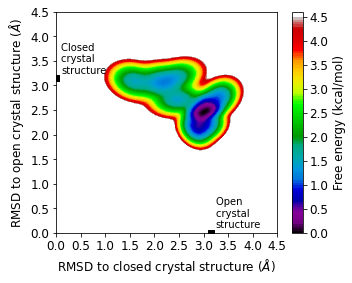

In [12]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=99, show_data=False, 
              figsize= [5, 5], transition_point_size=1, core_point_size=5, core_point_edgecolor='k', 
              colormap2='spectral',clust_point_edgecolor='w', clust_point_facecolor='', 
              clust_point_size=5, clust_point_linewidth=4, clust_point_marker='s',legend=None,
              extend=None, rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
              filename='./plots/2-Without_IPA/1-FES_with_IPA_dt5', ax=None)

## Clustering for the limited dataset

In [13]:
labels, cluster_centers = fec.cluster(coords, FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 9358.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [106142  69565  97665 101741  31975  51403]


In [14]:
with open('./pickled/2-Without_IPA/labels_dt5.pickle', 'wb') as outf:
    pickle.dump(labels, outf)
with open('./pickled/2-Without_IPA/cluster_centers_dt5.pickle', 'wb') as outf:
    pickle.dump(cluster_centers, outf)
    
# with open('./pickled/2-Without_IPA/labels_dt5.pickle', 'rb') as inf:
#     labels=pickle.load(inf)
# with open('./pickled/2-Without_IPA/cluster_centers_dt5.pickle', 'rb') as inf:
#     cluster_centers=pickle.load(inf)
    
# fec.labels_ = np.copy(labels)
# fec.cluster_centers_ = np.copy(cluster_centers)

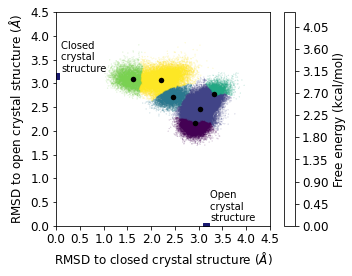

In [15]:
fec.pathways_ = None
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.05, core_point_edgecolor=None, 
              colormap2='viridis',clust_point_edgecolor=None, clust_point_facecolor='k', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/2-Without_IPA/2-Cluster_map_with_IPA_dt5.png', ax=None)

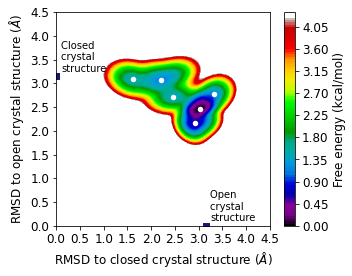

In [16]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.0, core_point_edgecolor='k', 
              colormap2='jet',clust_point_edgecolor='k', clust_point_facecolor='w', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=1,
              filename='./plots/2-Without_IPA/3-FES_with_IPA_with_cluster_centres_dt5.png', ax=None)

To use the same colour code as for the MSM

In [18]:
hexlist=[]

cmap = cm.get_cmap("Blues",8)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
# sns.set_palette(hexlist)
# sns.palplot(sns.color_palette())

my_cmap=ListedColormap([hexlist[7],hexlist[6],hexlist[4],hexlist[5],hexlist[2],hexlist[3]])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


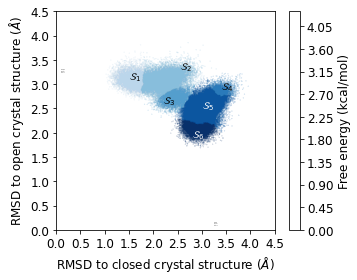

In [20]:
fec.pathways_ = None
fig, ax = plt.subplots()
fec.visualize(fontsize=12, savefig=False, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.05, core_point_edgecolor=None, 
              colormap2=my_cmap,clust_point_edgecolor=None, clust_point_facecolor=None, 
              clust_point_size=0, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=0, rmsd_point_fontsize=0, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/2-Without_IPA/2-Cluster_map_with_IPA_dt5', ax=ax)


ax.text(1.5,3.1,r'$\mathcal{S}_1$',c='k')
ax.text(2.55,3.3,r'$\mathcal{S}_2$',c='k')
ax.text(2.2,2.6,r'$\mathcal{S}_3$',c='k')
ax.text(3.4,2.9,r'$\mathcal{S}_4$',c='k')
ax.text(3.,2.5,r'$\mathcal{S}_5$',c='w' )
ax.text(2.8,1.9,r'$\mathcal{S}_6$',c='w' )

fig.savefig('./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5.png', dpi=600)

We can then look at the population of each state for the limited dataset

In [21]:
# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)
state_populations*100

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([14.68848471, 57.59854055,  5.22140527,  0.        ,  1.6142407 ,
        5.55586268, 15.32146608])

## Assigning clusters to the full dataset

The trajectory is therefore first loaded with a stride of 1

In [22]:
traj_all = pt.iterload(traj_list, topfile, stride=1)

The RMSD is calculated and the Z array constructed

In [23]:
rmsd0=pt.rmsd(traj_all,ref=rf0, mask="@CA,N,C,O")
rmsd1=pt.rmsd(traj_all,ref=rf1, mask="@CA,N,C,O")
rmsd2=pt.rmsd(traj_all,ref=rf2, mask="@CA,N,C,O")
rmsd3=pt.rmsd(traj_all,ref=rf3, mask="@CA,N,C,O")
rmsd4=pt.rmsd(traj_all,ref=rf4, mask="@CA,N,C,O")
rmsd5=pt.rmsd(traj_all,ref=rf5, mask="@CA,N,C,O")

rmsd_closed_all=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)

rmsd_open_all=pt.rmsd(traj_all,ref=rfopen, mask="@CA,N,C,O")

In [24]:
Z_all=[]
for i in range(0,len(rmsd_open_all)):
    a=np.array([rmsd_closed_all[i],rmsd_open_all[i]])
    Z_all.append(a)
Z_all=np.array(Z_all)

In [25]:
with open('./pickled/2-Without_IPA/Z_dt1.pickle', 'wb') as outf:
    pickle.dump(Z_all, outf)
    
# with open('./pickled/2-Without_IPA/Z_dt1.pickle', 'rb') as inf:
#     Z_all = pickle.load(inf)

Then we can assign all the points to the pre-computed clusters

In [26]:
labels_all = fec.evaluate_clustering(Z_all, assign_transition_points=True)

Assigning cluster labels based on precomputed density model clustering.
Assigning cluster indices to non-core cluster points.


In [27]:
with open('./pickled/2-Without_IPA/labels_all.pickle', 'wb') as outf:
    pickle.dump(labels_all, outf)

# with open('./pickled/2-Without_IPA/labels_all.pickle', 'rb') as inf:
#     labels_all=pickle.load(inf)

    
# fec.labels_ = np.copy(labels_all)


In [28]:
fec.labels_ = np.copy(labels_all)

In [29]:
# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)
state_populations*100

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([14.67667918, 58.04477819,  5.23710193,  0.        ,  1.59643999,
        5.24822695, 15.19677374])

## FES for the full dataset

In [30]:
fec_all = FEC.FreeEnergyClustering(Z_all, min_n_components=10, max_n_components=10, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=5, n_grids=150, n_splits=1,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 150
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 10
   max_n_components = 10
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*


In [31]:
coords_all, FE_landscape_all, FE_points_all = fec_all.landscape()

Estimating density with GMM.
# Components = 10
Identifying final model with 10 components.
Evaluating density in landscape
Density grid shape: [150, 150]


In [32]:
with open('./pickled/2-Without_IPA/coords_dt1.pickle', 'wb') as outf:
    pickle.dump(coords_all, outf)
with open('./pickled/2-Without_IPA/FE_landscape_dt1.pickle', 'wb') as outf:
    pickle.dump(FE_landscape_all, outf)
with open('./pickled/2-Without_IPA/FE_points_dt1.pickle', 'wb') as outf:
    pickle.dump(FE_points_all, outf)
    
# with open('./pickled/2-Without_IPA/coords_dt1.pickle', 'rb') as inf:
#     coords_all = pickle.load(inf)
# with open('./pickled/2-Without_IPA/FE_landscape_dt1.pickle', 'rb') as inf:
#     FE_landscape_all = pickle.load(inf)
# with open('./pickled/2-Without_IPA/FE_points_dt1.pickle', 'rb') as inf:
#     FE_points_all = pickle.load(inf)

# fec_all.FE_points_ = np.copy(FE_landscape_all)
# fec_all.FE_landscape_ = np.copy(FE_landscape_all)
# fec_all.coords_ = coords_all 

/mnt/storage/scratch/el14718/10-ALKEIG/12-Analysis_4/11-InfleCS_clustering_3/free_energy_clustering/GMM_free_energy.py:537: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("nipy_spectral"))
  my_cmap.set_over('white')


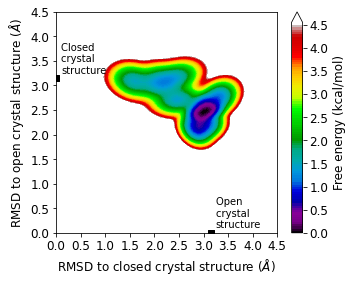

In [33]:
fec_all.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=99, show_data=False, 
              figsize= [5, 5], transition_point_size=1, core_point_size=5, core_point_edgecolor='k', 
              colormap2='spectral',clust_point_edgecolor='w', clust_point_facecolor='', 
              clust_point_size=5, clust_point_linewidth=4, clust_point_marker='s',legend=None,
              extend='max', rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
              filename='./plots/2-Without_IPA/1-FES_with_IPA_dt1', ax=None)

In [34]:
fec_all.labels_ = np.copy(labels_all)

## the cluster centers are frame indexes so they are not valid here
# fec_all.cluster_centers_ = np.copy(cluster_centers)

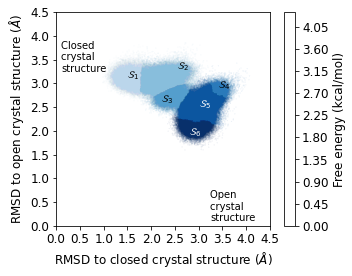

In [35]:
fec_all.pathways_ = None
fig, ax = plt.subplots()
fec_all.visualize(fontsize=12, savefig=False, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.005, core_point_edgecolor=None, 
              colormap2=my_cmap,clust_point_edgecolor=None, clust_point_facecolor=None, 
              clust_point_size=0, clust_point_linewidth=0, clust_point_marker='.',legend=None,
              extend='neither', rmsd_point_size=0, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt1', ax=ax,core_point_marker='.')


ax.text(1.5,3.1,r'$\mathcal{S}_1$',c='k')
ax.text(2.55,3.3,r'$\mathcal{S}_2$',c='k')
ax.text(2.2,2.6,r'$\mathcal{S}_3$',c='k')
ax.text(3.4,2.9,r'$\mathcal{S}_4$',c='k')
ax.text(3.,2.5,r'$\mathcal{S}_5$',c='w' )
ax.text(2.8,1.9,r'$\mathcal{S}_6$',c='w' )

fig.savefig('./plots/2-Without_IPA/2-Cluster_map_with_IPA_dt1.png', dpi=600)

## Creating crisp clustering for extracting representative structures

Note that the GMM needs to be reconstructed form scratch running the following command, else the clustering doesn't work

In [36]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=10, max_n_components=10, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=5, n_grids=151, n_splits=1,stack_landscapes=False)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 10
   max_n_components = 10
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 10
Identifying final model with 10 components.
Evaluating density in landscape
Density grid shape: [151, 151]


In [37]:
labels, cluster_centers = fec.cluster(coords,FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 9452.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [106142  69565  97665 101741  31975  51403]


In [38]:
with open('./pickled/2-Without_IPA/labels_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(labels, outf)
with open('./pickled/2-Without_IPA/cluster_centers_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(cluster_centers, outf)
    
# with open('./pickled/2-Without_IPA/labels_dt5_crisp.pickle', 'rb') as inf:
#     labels=pickle.load(inf)
# with open('./pickled/2-Without_IPA/cluster_centers_dt5_crisp.pickle', 'rb') as inf:
#     cluster_centers=pickle.load(inf)
    
# fec.labels_ = np.copy(labels)
# fec.cluster_centers_ = np.copy(cluster_centers)

In [39]:
state_populations = fec.population_states(n_sampled_points=10000)
state_populations

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([0.14458162, 0.58737997, 0.0521262 , 0.        , 0.01481481,
       0.0515775 , 0.14951989])

In [40]:
from collections import Counter
Counter(labels)

Counter({5.0: 5544, 6.0: 15864, 3.0: 5357, 2.0: 66939, 4.0: 2870, 1.0: 12801})

In [42]:
# Just in case
labels_old=labels
cluster_centers_old=cluster_centers

In [73]:
# To retry
labels=labels_old
cluster_centers=cluster_centers_old

In [74]:
i=1
threshold=1
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [75]:
i=2
threshold=1
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [76]:
i=3
threshold=0.35
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [77]:
i=4
threshold=3
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [78]:
i=5
threshold=0.25
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [79]:
i=6
threshold=0.5
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

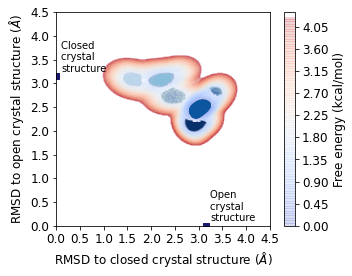

In [80]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
                  ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
                  vmax=4.25, colormap='coolwarm', lim=0.1, n_contour_levels=100, show_data=True, 
                  figsize= [5, 5], transition_point_size=0, core_point_size=0.0005, 
                  core_point_edgecolor=None, 
                  colormap2=my_cmap,clust_point_edgecolor=None, clust_point_facecolor=None, 
                  clust_point_size=0, clust_point_linewidth=0, 
                  clust_point_marker='.',legend=None,
                  extend=None, rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
                  core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.2,
                  filename='./plots/2-Without_IPA/5-crisp_cluster_dt5_extended', 
                  ax=None, core_point_marker='.')

In [81]:
Counter(labels)

Counter({0.0: 50659,
         5.0: 2452,
         3.0: 3575,
         2.0: 37091,
         4.0: 1442,
         1.0: 8097,
         6.0: 6059})

Note that `label==0` corresponds to the non-assigned transition points! The rest are the crisp clusters (from 1 to 6) in the same order than previoulsy

In [82]:
with open('./pickled/2-Without_IPA/labels_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(labels, outf)
with open('./pickled/2-Without_IPA/cluster_centers_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(cluster_centers, outf)
    
# with open('./pickled/2-Without_IPA/labels_dt5_crisp.pickle', 'rb') as inf:
#     labels=pickle.load(inf)
# with open('./pickled/2-Without_IPA/cluster_centers_dt5_crisp.pickle', 'rb') as inf:
#     cluster_centers=pickle.load(inf)
    
# fec.labels_ = np.copy(labels)
# fec.cluster_centers_ = np.copy(cluster_centers)

## Extracting representative structures

Need to first load trajectory in memory as the following `t[labels==i]` doesn't work with `pt.iterload`.

In [83]:
t = pt.load(traj_list, topfile, stride=5)

In [84]:
rf=[rf0,rf1,rf2,rf3,rf4,rf5]
toplist=sorted(glob('../1-Trajectories/0-Parm_rst/closed6_dry_rot*.parm7'))
toplist

['../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7']

In [85]:
sample_number=1000

for j in range(1,7):
    
    print("starting with", j)
    
    clust_traj = t[labels == j]
    print("Total number of frames:", clust_traj.n_frames)


    if clust_traj.n_frames > 0:
        
        randomlist = random.sample(range(0, clust_traj.n_frames), sample_number)
        tmp_traj=clust_traj[randomlist]
        print("Number of sampled frames:", tmp_traj.n_frames)
        
        if tmp_traj.n_frames > 0:

            new_traj = pt.Trajectory(top=topfile) # Empty trajectory
            min_ref=[]
    
            for i in range(0,tmp_traj.n_frames,1):

                rmsd0=pt.rmsd(tmp_traj[i:i+1],ref=rf0, mask="@CA,N,C,O")
                rmsd1=pt.rmsd(tmp_traj[i:i+1],ref=rf1, mask="@CA,N,C,O")
                rmsd2=pt.rmsd(tmp_traj[i:i+1],ref=rf2, mask="@CA,N,C,O")
                rmsd3=pt.rmsd(tmp_traj[i:i+1],ref=rf3, mask="@CA,N,C,O")
                rmsd4=pt.rmsd(tmp_traj[i:i+1],ref=rf4, mask="@CA,N,C,O")
                rmsd5=pt.rmsd(tmp_traj[i:i+1],ref=rf5, mask="@CA,N,C,O")

                rmsd_all=np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5])

                ali_struct=np.where(rmsd_all == np.nanmin(rmsd_all, axis=0))
                nb=int(ali_struct[0])
                new_frame=pt.align(tmp_traj[i:i+1],ref=rf[nb],mask="@CA,N,C,O", top=toplist[nb])
                new_traj.append(new_frame)
                min_ref.append(nb)

            new_traj.save('./sample_structures/2-Without_IPA/1-Crisp_1000/ms{}.xtc'.format(j), overwrite=True)  

            print("Fraction original trajectories", float(new_traj.n_frames/tmp_traj.n_frames))

            with open('./sample_structures/2-Without_IPA/1-Crisp_1000/ref_frame_ms{}.pickle'.format(j)
                      , 'wb') as outf:
                pickle.dump(min_ref, outf)
    print("finished with", j)
        

starting with 1
Total number of frames: 8097
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 1
starting with 2
Total number of frames: 37091
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 2
starting with 3
Total number of frames: 3575
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 3
starting with 4
Total number of frames: 1442
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 4
starting with 5
Total number of frames: 2452
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 5
starting with 6
Total number of frames: 6059
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 6
